### Alternative approach using SVM

In [37]:
import gzip
import numpy as np
from sklearn.cross_validation import KFold
from sklearn.cross_validation import StratifiedKFold
from sklearn import svm
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import time
from sklearn.preprocessing import Imputer
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [38]:
start = time.time()
npzfile = np.load('HCS_48x48.npz')
print ("Loaded data in " + str(time.time() - start))
npzfile.files
start = time.time()
cell_rows = npzfile['arr_0']
X = npzfile['arr_1']
Y = npzfile['arr_2']
print ("Loaded data in " + str(time.time() - start))
np.shape(cell_rows), np.shape(Y), np.shape(X), type(X)

Loaded data in 0.00086498260498
Loaded data in 4.5109000206


((52950,), (52950,), (52950, 5, 48, 48), numpy.ndarray)

### Loading the features of the cells

In [39]:
cells_all = pd.read_csv('/home/dueo/data/Genedata/Cells.csv')
cells = cells_all.iloc[cell_rows]
np.shape(cells)

(52950, 407)

In [40]:
cells.ix[0:2,'AreaShape_Area':]

,AreaShape_Area,AreaShape_Center_X,AreaShape_Center_Y,AreaShape_Compactness,AreaShape_Eccentricity,AreaShape_EulerNumber,AreaShape_Extent,AreaShape_FormFactor,AreaShape_MajorAxisLength,AreaShape_MaxFeretDiameter,...,Texture_Variance_ER_3_0,Texture_Variance_ER_5_0,Texture_Variance_Golgi_Actin_3_0,Texture_Variance_Golgi_Actin_5_0,Texture_Variance_Hoechst_3_0,Texture_Variance_Hoechst_5_0,Texture_Variance_Mito_3_0,Texture_Variance_Mito_5_0,Texture_Variance_Nucleoli_3_0,Texture_Variance_Nucleoli_5_0
0,5520,542,43,1.297952,0.837477,1,0.484295,0.141449,118.346136,142.618372,...,0.963408,0.942669,1.432731,1.470543,2.608476,2.653153,1.357492,1.328036,1.516640,1.495042
1,6126,317,52,1.230381,0.769741,1,0.609977,0.375944,116.594822,130.782262,...,1.070573,1.084703,1.917686,1.915602,2.261544,2.322472,1.621720,1.628327,1.489087,1.491358
2,11618,438,82,1.091077,0.522378,1,0.625431,0.284604,136.470704,152.463110,...,0.703105,0.714262,1.621151,1.623899,1.664106,1.705266,1.610848,1.621337,1.679954,1.700747


### Extracting the features and imputing NaNs

In [42]:
X_features = np.asmatrix(cells.ix[:,'AreaShape_Area':])
np.shape(X_features)

(52950, 396)

In [43]:
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(X_features)
X_features = imp.transform(X_features)

### Normalization

In [44]:
Xmean = X_features.mean(axis = 0)
XStd = np.sqrt(X_features.var(axis=0))
X = (X_features-Xmean)/(XStd + 0.01)

In [46]:
np.max(X[:,1])

1.8173680921031092

In [47]:
np.min(X), np.max(X), np.mean(X)

(-69.705828219351631, 132.78221451686983, -2.7136455336971616e-18)

In [48]:
Y = np.asarray(Y,dtype='int32')

### Some examples (after normalization)
rows are the different compounds

## Splitting in training and test-set



#### Version 1
80%, 20% randomly choosen

In [13]:
# Currently a Acc. of 0.8250
split = 40000
X_train = X[0:split,:]
Y_train = Y[0:split]
X_test = X[split:,:]
Y_test = Y[split:]

#### Version 3 (Separation of complete well)
Separating a complete well from the training set and use this for testing

In [12]:
#idx_test = np.asarray(np.recfromtxt ('test_set_data.csv'))
#np.sum(idx_test)

2854

In [15]:
#X_train = X[idx_test== False]
#X_test = X[idx_test]

#Y_train = Y[idx_test== False]
#Y_test = Y[idx_test]

#X_test.shape, Y_test.shape, X_train.shape, Y_train.shape

#### NO DMSO and  (Separation of complete well)

In [49]:
Y = Y -1
idx_DMSO = np.asarray(np.recfromtxt ('DMSO_data.csv'))
print('Number of DMSO {}'.format(np.sum(idx_DMSO)))

Number of DMSO 40783


In [50]:
idx_test_all = np.asarray(np.recfromtxt ('test_set_data.csv'))

idx_train = (idx_test == False) & (idx_DMSO == False)
idx_test  = idx_test & (idx_DMSO == False)

X_train = X[idx_train]
Y_train = Y[idx_train]

X_test = X[idx_test]
Y_test = Y[idx_test]


X_test.shape, Y_test.shape, X_train.shape, Y_train.shape #1964 and 10203

((1964, 396), (1964,), (10203, 396), (10203,))

In [18]:
# Currently a Acc. of 0.8976
if False:
    np.random.seed(seed=42)
    perm1 = np.random.permutation(len(Y))
    print('Sum of permutation {0}'.format(np.sum(perm1))) #1401824775
    N_split = int(len(Y) * 0.8)
    N_split
    idx_train  = perm1[:N_split]
    idx_test  = perm1[N_split:]


    X_train = X[idx_train,:]
    Y_train = Y[idx_train]
    X_test = X[idx_test,:]
    Y_test = Y[idx_test]

Sum of permutation 1401824775


#### Permuting the training set

In [51]:
perm = np.random.permutation(len(Y_train))
X_train_perm = X_train[perm]
Y_train_perm = Y_train[perm]

### 10 Fold X-Validation

We use a 10 fold crossvalidation on the training set to find the optimal parameters

### Sampling 

For the SVM we sample so that the classes have equal proportions.

#### In the case of no DSMO

In [52]:
hist = np.histogram(Y_train_perm, bins=[0, 1, 2, 3,4])
NMAX = np.min(hist[0])
NMAX = 352
hist, NMAX

((array([1520, 8331,  352,    0]), array([0, 1, 2, 3, 4])), 352)

In [53]:
idx2 = np.argwhere(Y_train_perm == 2)[0:NMAX]
idx1 = np.argwhere(Y_train_perm == 1)[0:NMAX]
idx0 = np.argwhere(Y_train_perm == 0)[0:NMAX]
idx_d = np.concatenate((idx0,idx1,idx2))[:,0] #Orderedness is problem in studip k-fold
perm_d = np.random.permutation(len(idx_d))
idx = idx_d[perm_d]
idx.shape

(1056,)

In [54]:
XX1 = X_train_perm[idx]
YY1 = Y_train_perm[idx]
np.shape(XX1), np.shape(YY1),np.shape(X_train_perm),np.shape(idx)

((1056, 396), (1056,), (10203, 396), (1056,))

In [21]:
np.histogram(YY1,  bins=[0, 1, 2, 3,4])

(array([352, 352, 352,   0]), array([0, 1, 2, 3, 4]))

In [55]:
YY1[1:10]

array([0, 2, 1, 0, 0, 0, 0, 2, 0], dtype=int32)

In [56]:
def eval_10_Fold(C = 0.5):
    N = len(XX1)
    kf = KFold(N, n_folds=10)
    acc = 0.0
    rounds = 0.0
    for train, test in kf:
        model = svm.SVC(kernel='linear', C=C).fit(XX1[train,],YY1[train])
        res = model.predict(XX1[test])
        acc += sum(res == YY1[test])/float(len(test)) #Accuracy
        rounds += 1.0
        print('round ={0} C={1} acc (cumulated over the folds) ={2}'.format(rounds, C, acc / rounds))
    return acc

In [57]:
#Cs = (1e-3,5e-3,1e-2,5e-2,1e-1,1e0,1e+1,1e2,1e3)
Cs = (1e-3,5e-3,1e-2,5e-2,1e-1,1e0,1e+1)
#Cs = np.logspace(np.log10(0.001), 2,20)#Schon Komisch, dass man noch ein log drum muss
res = np.zeros(len(Cs))
for i,C in enumerate(Cs):
    res[i] = eval_10_Fold(C)

round =1.0 C=0.001 acc (cumulated over the folds) =0.924528301887
round =2.0 C=0.001 acc (cumulated over the folds) =0.919811320755
round =3.0 C=0.001 acc (cumulated over the folds) =0.924528301887
round =4.0 C=0.001 acc (cumulated over the folds) =0.929245283019
round =5.0 C=0.001 acc (cumulated over the folds) =0.918867924528
round =6.0 C=0.001 acc (cumulated over the folds) =0.921383647799
round =7.0 C=0.001 acc (cumulated over the folds) =0.920369657297
round =8.0 C=0.001 acc (cumulated over the folds) =0.91722821204
round =9.0 C=0.001 acc (cumulated over the folds) =0.917959468903
round =10.0 C=0.001 acc (cumulated over the folds) =0.916639712489
round =1.0 C=0.005 acc (cumulated over the folds) =0.943396226415
round =2.0 C=0.005 acc (cumulated over the folds) =0.929245283019
round =3.0 C=0.005 acc (cumulated over the folds) =0.927672955975
round =4.0 C=0.005 acc (cumulated over the folds) =0.943396226415
round =5.0 C=0.005 acc (cumulated over the folds) =0.939622641509
round =6.0

((0.001, 0.005, 0.01, 0.05, 0.1, 1.0, 10.0),
 array([ 9.16639712,  9.4034142 ,  9.43189578,  9.38481581,  9.35651393,
         9.27097934,  9.27097934]))

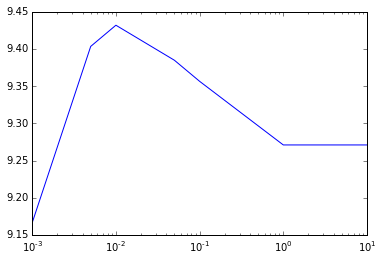

In [59]:
plt.semilogx(Cs,res)
#plt.plot(Cs,res)

(Cs,res)

### Evaluation on the test set

Training the model on the whole training data set

In [26]:
#model = svm.SVC(kernel='linear', C=0.01).fit(XX1,YY1)
model = svm.SVC(probability=True, C=0.01).fit(XX1,YY1)
#model = svm.SVC(probability=True, C=0.05).fit(XX,YY) #Fit on not sampled

In [27]:
X_test.shape

(1964, 396)

In [72]:
pred = model.predict(X_test)

In [73]:
model.predict(X_test)
pred_prob = model.predict_proba(X_test)

In [74]:
sum(pred == Y_test)/float(len(Y_test))

0.67769857433808556

### Fisher LDA

In [65]:
from sklearn.lda import LDA
clf = LDA()
clf.fit(X_train_perm, Y_train_perm)

/usr/local/lib/python2.7/dist-packages/sklearn/lda.py:161: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


LDA(n_components=None, priors=None)

In [67]:
Y_pred_lda = clf.predict(X_test)

In [68]:
sum(Y_pred_lda == Y_test)/float(len(Y_test))

0.97861507128309577

In [70]:
np.histogram(Y_pred_lda,bins=(0,1,2,3))

(array([ 478, 1426,   60]), array([0, 1, 2, 3]))

In [71]:
confusion_matrix(Y_pred_lda, Y_test)

array([[ 453,   22,    3],
       [  14, 1411,    1],
       [   1,    1,   58]])

In [80]:
pred_prob_lda = clf.predict_proba(X_test)

### Random Forest

In [81]:
from sklearn.ensemble import RandomForestClassifier

In [92]:
clf = RandomForestClassifier(n_jobs=8,n_estimators=500)
clf.fit(X_train_perm, Y_train_perm)

RandomForestClassifier(bootstrap=True, compute_importances=None,
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
            min_samples_split=2, n_estimators=500, n_jobs=8,
            oob_score=False, random_state=None, verbose=0)

In [93]:
Y_pred_rf = clf.predict(X_test)

In [94]:
sum(Y_pred_rf == Y_test)/float(len(Y_test))

0.93126272912423624

In [34]:
%load_ext rpy2.ipython
%Rpush pred_prob
%Rpush Y_test

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [35]:
%%R
save(pred_prob, Y_test, file='Test_SVM_C0.01_SingleWell_NODMSO.Rdata')

### Calucation of the confusion matrix

In [30]:
m = confusion_matrix(pred, Y_test)
m

array([[494,  21, 275,   0],
       [ 38, 324, 307,   2],
       [190,  49, 736,   0],
       [168,  74, 116,  60]])

In [31]:
m.astype('float') / ((m.sum(axis=0)[np.newaxis,:]))

array([[ 0.55505618,  0.04487179,  0.19177127,  0.        ],
       [ 0.04269663,  0.69230769,  0.21408647,  0.03225806],
       [ 0.21348315,  0.10470085,  0.51324965,  0.        ],
       [ 0.18876404,  0.15811966,  0.08089261,  0.96774194]])

In [30]:
names_col = ('PACLITAXEL True', 'METOCLOPRAMIDE True', 'DIGOXIN True')
m = confusion_matrix(pred, Y_test)
df = pd.DataFrame(m)
df.columns = names_col
names = ('PACLITAXEL Pred', 'METOCLOPRAMIDE Pred', 'DIGOXIN Pred')
df.index = names
df

,PACLITAXEL True,METOCLOPRAMIDE True,DIGOXIN True
PACLITAXEL Pred,335,370,2
METOCLOPRAMIDE Pred,65,936,0
DIGOXIN Pred,68,128,60


In [31]:
#cm_normalized = m.astype('float') / ((m.sum(axis=1)[:, np.newaxis]))
cm_normalized = m.astype('float') / ((m.sum(axis=0)[np.newaxis,:]))
print('Normalized confusion matrix')


df = pd.DataFrame(cm_normalized)
df.columns = names_col
df.index = names
df

Normalized confusion matrix


,PACLITAXEL True,METOCLOPRAMIDE True,DIGOXIN True
PACLITAXEL Pred,0.715812,0.258020,0.032258
METOCLOPRAMIDE Pred,0.138889,0.652720,0.000000
DIGOXIN Pred,0.145299,0.089261,0.967742


In [34]:
np.mean(cm_normalized[np.diag_indices(4)])

0.68208886472295238

In [35]:
1-np.mean(cm_normalized[np.diag_indices(4)])

0.31791113527704762